### Курсовая работа 

**матерьялы к проекту:** датасет Black Friday Sales  

**Задание:** построить модель для предсказания суммы покупок покупателем , необходимо получить коэффициент детерминации больше 0.6

* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка пропусков](#nan)
* [3. Преобразование категориальных переменных в числовые](#transform)
* [4. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

In [48]:
#Подключение библиотек и скриптов
import numpy as np
import pandas as pd
import random
#import pickle # тут пользоваться pikle не буду поэтому отключаю импорт библиотеки

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
#from sklearn.ensemble import RandomForestClassifier #долго обучаеться и дает плохие предсказания, поэтому отклюючеа

%matplotlib inline


In [49]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [50]:
# пути к файлам
__dir = ''#'Black Friday Sales/data/'
TRAIN_DATASET_PATH = __dir + 'train.csv'
TEST_DATASET_PATH = __dir + 'test.csv'

### Загрузка данных<a class='anchor' id='load'>

**описание полей датасета**  
●	User_ID - идентификационный номер покупателя  
●	Product_ID - идентификационный номер товара  
●	Age - возраст покупателя  
●	Occupation - род деятельности покупателя  
●	City_Category - город проживания  
●	Stay_In_Current_City_Years - как долго покупатель живет в этом городе  
●	Marital_Status - семейное положение покупателя  
●	Product_Category_1 - категория товара 1  
●	Product_Category_2 - категория товара 2  
●	Product_Category_3 - категория товара 3  
●	Purchase - сумма покупок   

In [51]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [52]:
train_df.sample(5) # выведим 5 случайных записей

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
39197,1002916,P00108442,M,46-50,2,C,3,0,5,NaN,NaN,8829
66783,1004281,P00254542,M,55+,13,A,4+,0,8,13.0,NaN,7867
14234,1001271,P00033342,F,46-50,6,C,3,1,5,14.0,NaN,8820
13307,1005003,P00125942,M,36-45,12,C,1,0,1,2.0,15.0,15598
35336,1004813,P00053842,F,36-45,9,C,3,1,4,5.0,12.0,2850


In [53]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     80000 non-null  int64  
 1   Product_ID                  80000 non-null  object 
 2   Gender                      80000 non-null  object 
 3   Age                         80000 non-null  object 
 4   Occupation                  80000 non-null  int64  
 5   City_Category               80000 non-null  object 
 6   Stay_In_Current_City_Years  80000 non-null  object 
 7   Marital_Status              80000 non-null  int64  
 8   Product_Category_1          80000 non-null  int64  
 9   Product_Category_2          54892 non-null  float64
 10  Product_Category_3          24331 non-null  float64
 11  Purchase                    80000 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 7.3+ MB


в датасете в колонках Product_Category_2 и Product_Category_3 есть пропущенные данные.

In [54]:
test_df.sample(5) # выведим 5 случайных записей

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
17613,1002769,P00110742,M,26-35,7,C,0,0,1,2.0,8.0
14289,1001017,P00312742,M,36-45,0,B,2,0,15,NaN,NaN
1503,1002536,P00303242,M,55+,13,B,4+,1,5,8.0,NaN
13631,1005501,P00057242,M,26-35,2,A,3,0,5,NaN,NaN
14309,1001341,P00225642,M,18-25,7,C,3,0,11,15.0,NaN


In [55]:
df = train_df
df.shape

(80000, 12)

### Приведение типов

In [56]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

## 1. EDA  <a class='anchor' id='eda'>

Делаем EDA для:
- Обработка пропусков
- Преобразование категориальных признаков в числовые

### 2. Обработка пропусков  <a class='anchor' id='nan'>

In [57]:
df.isnull().sum()

User_ID                           0
Product_ID                        0
Gender                            0
Age                               0
Occupation                        0
City_Category                     0
Stay_In_Current_City_Years        0
Marital_Status                    0
Product_Category_1                0
Product_Category_2            25108
Product_Category_3            55669
Purchase                          0
dtype: int64

In [58]:
df["Product_Category_2"].describe()

count    54892.000000
mean         9.851873
std          5.079163
min          2.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         18.000000
Name: Product_Category_2, dtype: float64

In [59]:
# в даном датасете можно заменить пропущенные значения в столбце Product_Category_2 на среднее значения по этому столбцу
df["Product_Category_2"] = df["Product_Category_2"].fillna(value = df["Product_Category_2"].mean())

In [60]:
df["Product_Category_3"].describe()

count    24331.000000
mean        12.676421
std          4.109343
min          3.000000
25%          9.000000
50%         14.000000
75%         16.000000
max         18.000000
Name: Product_Category_3, dtype: float64

In [61]:
mediana = df["Product_Category_3"].median()
moda = df["Product_Category_3"].mode()
print(f'медиана= {mediana}, мода= {moda}')

медиана= 14.0, мода= 0    16.0
Name: Product_Category_3, dtype: float64


In [62]:
# заменим пропущенные значения в столбце Product_Category_3 на медиану
df["Product_Category_3"] = df["Product_Category_3"].fillna(value = df["Product_Category_3"].median())

In [63]:
df["Purchase"].describe()

count    80000.000000
mean      9243.933162
std       5021.298356
min         12.000000
25%       5679.750000
50%       8039.000000
75%      12046.000000
max      23961.000000
Name: Purchase, dtype: float64

In [64]:
# замениv пропущенные значения в столбце Purchase на среднее
df["Purchase"] = df["Purchase"].fillna(value = df["Purchase"].mean())

In [65]:
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

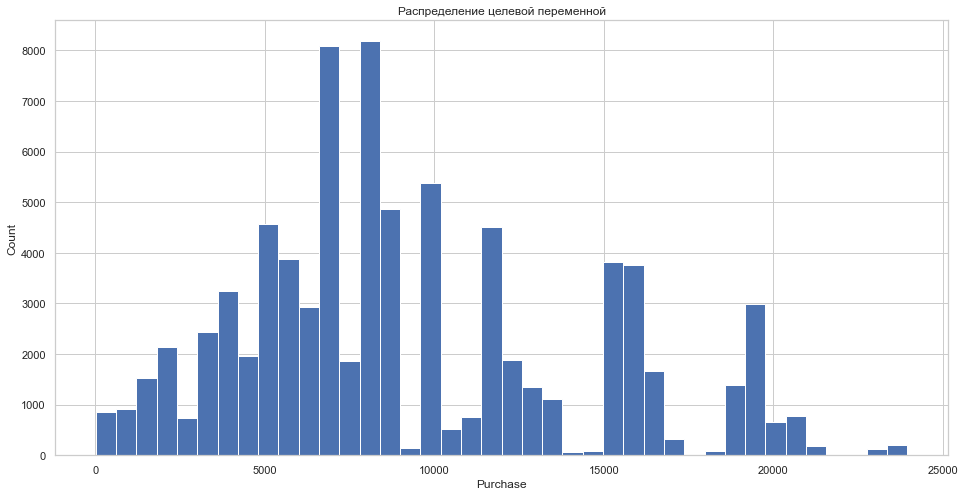

In [66]:
plt.figure(figsize = (16, 8))

df['Purchase'].hist(bins=40)
plt.ylabel('Count')
plt.xlabel('Purchase')

plt.title('Распределение целевой переменной')
plt.show()

### 3. Преобразование категориальных переменных в числовые  <a class='anchor' id='transform'>

In [67]:
df.select_dtypes(include='object').columns.tolist()

['Product_ID', 'Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [68]:
df['Gender'].value_counts()

M    60068
F    19932
Name: Gender, dtype: int64

In [69]:
#преобразуем признак пола если женщина 1, мужщина 2
df["Gender"] = df["Gender"].map({"F":1,"M":2}) 

In [70]:
df['Age'].value_counts()

26-35    32067
36-45    16025
18-25    14286
46-50     6777
51-55     5555
55+       3110
0-17      2180
Name: Age, dtype: int64

In [71]:
#преобразуем возраст
df["Age"] = df["Age"].map({'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 7})

In [72]:
df['City_Category'].value_counts()

B    33767
C    24778
A    21455
Name: City_Category, dtype: int64

In [73]:
#можно использовать get_dummies и будет создано 3 дополнительные колонки, но воспользуемся словорем и заменим категориальные переменные на числовые
df["City_Category"] = df["City_Category"].map({'A': 1, 'B': 2, 'C': 3})

In [74]:
df['Stay_In_Current_City_Years'].value_counts()

1     28287
2     14830
3     13853
4+    12250
0     10780
Name: Stay_In_Current_City_Years, dtype: int64

In [75]:
#в данном сталбце можно удалить + и значения станет числовым
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+','').astype(int)

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_21844\1171002432.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+','').astype(int)


In [76]:
df['Product_ID'].value_counts()

P00265242    272
P00025442    225
P00112142    224
P00058042    221
P00110742    220
            ... 
P00151642      1
P00240342      1
P00320642      1
P00060342      1
P00026842      1
Name: Product_ID, Length: 3256, dtype: int64

In [77]:
df['Product_ID'].nunique()

3256

In [78]:
#т.к. количество уникальных значений = количеству товаров(хотя id обязан быть уникальным) можно смело преобразовать строковую переменную в число
df['Product_ID'] = df['Product_ID'].str.replace('P','').astype(int)

In [79]:
# проверим после преобразования не потеряли ли значения, все ок, как было 3321 уникальных значений так и осталось :)
df['Product_ID'].nunique()

3256

In [80]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1004085,75742,1,3,6,1,1,0,8,14.0,14.0,7803
1,1005491,234842,2,2,7,1,1,0,5,6.0,16.0,6903
2,1003499,220142,2,3,3,1,2,0,1,15.0,14.0,15773
3,1000097,211242,1,4,3,3,3,0,8,12.0,14.0,8116
4,1005802,327142,1,3,0,1,4,0,8,15.0,14.0,6144


### 4. Разбиение на train и test  <a class='anchor' id='split'>

In [81]:
target = df.Purchase   #объявляем целеваую переменную
features = df.drop("Purchase", axis=1) #удаляем из датафрейма столбец с целевой переменной 

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)


### 5. Построение модели  <a class='anchor' id='modeling'>

In [82]:
rf_model = RandomForestRegressor(bootstrap=False, max_depth=27, max_features='sqrt', min_samples_leaf=2, min_samples_split=3,
 n_estimators=350, random_state=21, criterion='mse') #RandomForestClassifier(max_depth=4, n_estimators=100, random_state=21)
rf_model.fit(X_train_scaled, y_train)

d:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=27,
                      max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=3, n_estimators=350, random_state=21)

**Оценка модели**

Train R2:	0.932
Test R2:	0.684


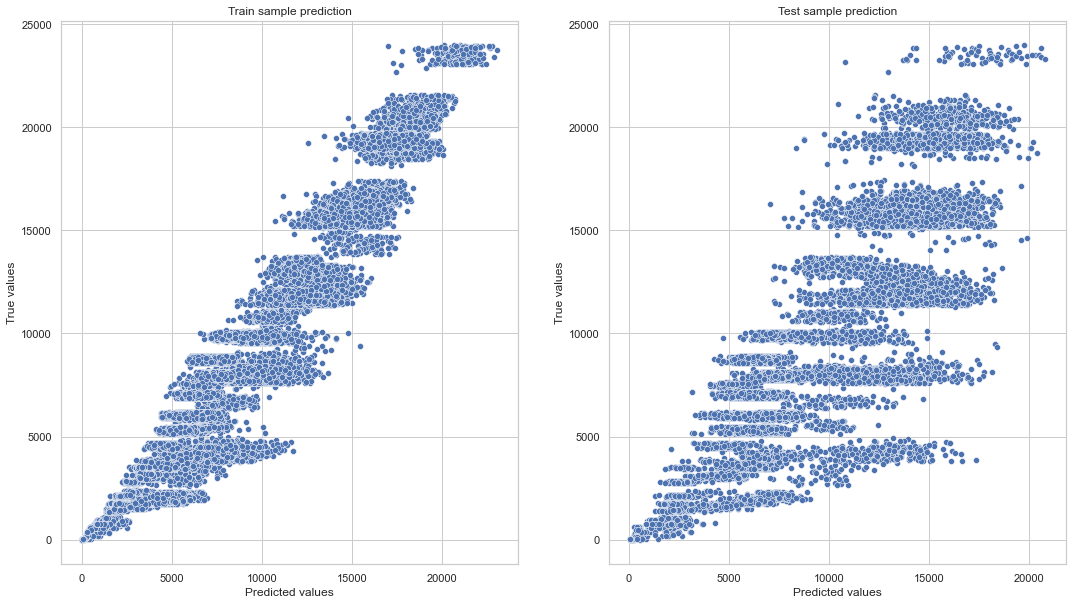

In [83]:
y_train_preds = rf_model.predict(X_train_scaled)
y_test_preds = rf_model.predict(X_test_scaled)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Кросс-валидация**

In [84]:
cv_score = cross_val_score(rf_model, X_train_scaled, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

d:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
d:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
d:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


array([0.6782157 , 0.67850643, 0.67170453])

In [85]:
cv_score.mean()

0.6761422198513817

**Важность признаков**

In [86]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
8,Product_Category_1,0.532075
1,Product_ID,0.130961
9,Product_Category_2,0.107644
0,User_ID,0.064399
10,Product_Category_3,0.057720
4,Occupation,0.036185
6,Stay_In_Current_City_Years,0.022205
3,Age,0.022084
5,City_Category,0.012343
7,Marital_Status,0.008226


### Метод главных компонент

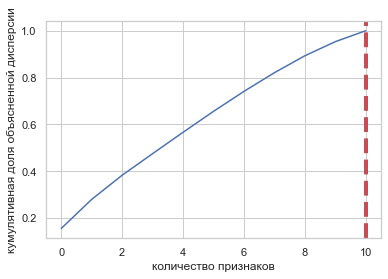

None

,кумулятивный коэффициент дисперсии
0,0.154839
1,0.279105
2,0.382367
3,0.474507
4,0.565814
5,0.655230
6,0.740572
7,0.820482
8,0.892809
9,0.953194


In [87]:
from sklearn.decomposition import PCA
pca_test = PCA(n_components=11)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('количество признаков')
plt.ylabel('кумулятивная доля объясненной дисперсии')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['кумулятивный коэффициент дисперсии'] = cvr
display(pca_df.head(11))

#на графики отображаеться кумулятивная важность в зависимости от количества признаков, график однородный, единственный признак что можно удалить из датафрейма это пол, он наименее имформативен

### Подбор гиперпараметров

In [88]:
# гиперпараметры гугл коллаб искались 3 с половиной часа, запускать не стоит

'''
{'bootstrap': False,
 'max_depth': 27,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 350}

from sklearn.model_selection import GridSearchCV
n_estimators = [300,500,700]
max_features = ['sqrt']
max_depth = [2,3,7,11,15]
min_samples_split = [2,3,4,22,23,24]
min_samples_leaf = [2,3,4,5,6,7]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
gs = GridSearchCV(rf_model, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_
'''

"\n{'bootstrap': False,\n 'max_depth': 27,\n 'max_features': 'sqrt',\n 'min_samples_leaf': 2,\n 'min_samples_split': 3,\n 'n_estimators': 350}\n\nfrom sklearn.model_selection import GridSearchCV\nn_estimators = [300,500,700]\nmax_features = ['sqrt']\nmax_depth = [2,3,7,11,15]\nmin_samples_split = [2,3,4,22,23,24]\nmin_samples_leaf = [2,3,4,5,6,7]\nbootstrap = [False]\nparam_grid = {'n_estimators': n_estimators,\n              'max_features': max_features,\n              'max_depth': max_depth,\n              'min_samples_split': min_samples_split,\n              'min_samples_leaf': min_samples_leaf,\n              'bootstrap': bootstrap}\ngs = GridSearchCV(rf_model, param_grid, cv = 3, verbose = 1, n_jobs=-1)\ngs.fit(X_train_scaled, y_train)\nrfc_3 = gs.best_estimator_\ngs.best_params_\n"

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [89]:
df = test_df

### 2. Обработка пропусков
df["Product_Category_2"] = df["Product_Category_2"].fillna(value = df["Product_Category_2"].mean())
df["Product_Category_3"] = df["Product_Category_3"].fillna(value = df["Product_Category_3"].median())
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
dtype: int64

In [90]:
### 3. Преобразование категориальных переменных в числовые  <a class='anchor' id='transform'>
df["Gender"] = df["Gender"].map({"F":1,"M":2}) 
df["Age"] = df["Age"].map({'0-17': 1, '18-25': 2, '26-35': 3, '36-45': 4, '46-50': 5, '51-55': 6, '55+': 7})
df["City_Category"] = df["City_Category"].map({'A': 1, 'B': 2, 'C': 3})
df['Stay_In_Current_City_Years'].value_counts()
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+','').astype(int)
df['Product_ID'] = df['Product_ID'].str.replace('P','').astype(int)

C:\Users\Dmitriy\AppData\Local\Temp\ipykernel_21844\2896061317.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].str.replace('+','').astype(int)


In [91]:
submission = pd.read_csv( __dir + 'sample_submission.csv')
submission.head()

,Id,Purchase
0,0,9000
1,1,9000
2,2,9000
3,3,9000
4,4,9000


In [92]:
predictions = rf_model.predict(test_df)
predictions

d:\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


array([5692.33689116, 5692.33689116, 6500.45330798, ..., 5446.70943785,
       5606.08628798, 5446.70943785])